In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import scipy
import scipy.stats as stats
from scipy.stats import binom
import matplotlib
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
import math
from skmultiflow.drift_detection.adwin import ADWIN

sns.set_style('darkgrid')
np.random.seed(4)

In [2]:
setted_reward = [
    [0.8, 0.2, 0.4, 0.3],
    [0.5, 0.3, 0.5, 0.6],
    [0.2, 0.4, 0.7, 0.6],
    [0.6, 0.8, 0.1, 0.3],
    [0.4, 0.5, 0.7, 0.8]
]

"""
We have pre-defined the rewards history and the samples retrieved by such rewards distributions
in order to evaluate the different strategy used to compute the expected reward in a time varying scenario
Otherwise the comparison is not consistent
"""

class IndependentAgent:
    def __init__(self, name, T, distribution, R, time_variation, period):
        self.name = name
        self.T = T #total amount of iterations
        self.R_history = {}
        self.R_history[0] = R #
        self.expectations = {}
        self.n_arms = len(R)
        self.distribution = distribution #typology of distribution: Bernoulli | Gaussian
        self.N = np.zeros(self.n_arms) #number of times an arm has been pulled
        self.U = np.ones(self.n_arms) #upper bound for each arm
        self.r = [[] for i in range(self.n_arms)]
        self.cum_r = np.zeros(self.n_arms) #summation of all the reward retrieved
        self.hat_R = np.zeros(self.n_arms) #estimation of the reward, simple average
        self.B = np.zeros(self.n_arms) #confidence bound of each arm
        self.ind = [] #keep tracks of the indices of the selected arm for each iteration
        self.rewards = np.zeros(self.T) #keep track of the reward for each iteration
        self.cum_rewards = []
        self.R_T = np.zeros(self.T) #keep track of the regret
        self.arms_label = ['arm_'+str(i) for i in range(1,self.n_arms+1)] #arms label used to plot charts
        self.UB = [] #UCB1 upper bound, Auer and Cesa-Bianchi
        self.time_variation = time_variation
        self.period = period
        self.best = []
        self.count = 0
        self.adaptive_win = dict((k, ADWIN()) for k in range(self.n_arms))

    def get_current_R(self):
        return self.R_history[max(self.R_history)]
        
    def compute_upper_bound(self,t):
        R = self.get_current_R()
        delta = np.array( [max(R)] *  (self.n_arms)) - np.array(R)
        delta = delta[np.nonzero(delta)]
        self.UB.append(8 * sum(1 / delta) * np.log(t+1) + (1 + np.pi**2/3) * sum(delta))
    
    def compute_RB(self, t):
        i = self.ind[t]
        self.hat_R[i] = sum(self.r[i])/self.N[i]
        for i in range(self.n_arms):
            #variance = max(0.01,stats.pvariance(self.r[i]))
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def compute_windowed_RB(self, t, w):
        i = self.ind[t]
        if(self.N[i] == 0):
            self.hat_R[i] = sum(self.r[i])/self.N[i]
        elif(self.N[i] < w):
            self.hat_R[i] = np.mean(self.r[i])
        else:
            self.hat_R[i] = np.mean(self.r[i][-w:])
        for i in range(self.n_arms):
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def compute_adaptive_windowed_RB(self, t):
        i = self.ind[t]
        self.adaptive_win[i].add_element(self.rewards[t])
        if self.adaptive_win[i].detected_change():
            print('Change detected in arm: ' + str(i) + ' - at iteration: ' + str(t))     
        self.hat_R[i] = self.adaptive_win[i].estimation
        for i in range(self.n_arms):
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def compute_weighted_RB(self, t, alpha=None):
        i = self.ind[t]
        
        if(alpha == None):
            variance = max(0.1,stats.pvariance(self.r[i]))
            alpha = self.N[i] / (self.N[i]+(variance*10))
        weight = [alpha**j for j in range(int(self.N[i]))]
        if(len(weight)==0):
            self.hat_R[i] = sum(self.r[i])/self.N[i]
        else:
            self.hat_R[i] = np.average(self.r[i],weights=weight[::-1])
            
        for i in range(self.n_arms):
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def change_reward(self,t):
        reward = []
        R = self.get_current_R()
        for i in range(self.n_arms):
            if(self.time_variation == 'step'):
                #reward.append(np.random.randint(1,100)/100)
                setted_reward = [
                    [0.8, 0.2, 0.4, 0.3],
                    [0.5, 0.3, 0.5, 0.6],
                    [0.2, 0.4, 0.7, 0.7],
                    [0.6, 0.8, 0.1, 0.3],
                    [0.4, 0.5, 0.7, 0.8]
                ]
                reward = setted_reward[int((t+1)/200)]
                #self.rewards[int((t+1)/200)] = []
            elif(self.time_variation == 'pos_log'):
                reward.append( min(1, R[i] + ((np.log(t+1))/(100*np.log(self.T)))) )
            elif(self.time_variation == 'neg_log'):
                reward.append( R[i] - ((np.log(t+1))/(2*np.log(self.T))) )
        self.R_history[t] = reward
    
    def generate_one_sample(self, pulled_arm):
        R = self.get_current_R()
        if (self.distribution == 'Binomial'):
            return np.random.binomial(1,R[pulled_arm])
        if (self.distribution == 'Gaussian'):
            return np.random.normal(R[pulled_arm], 0.05, 1)
    
    def start(self):
        for t in range(self.T):
            
            #change reward suddenly
            if((t+1) % self.period == 0 and (t+1)!=self.T):
                self.change_reward(t)
            
            #arm selection
            if(t < self.n_arms):
                pulled_arm = t
            else:
                for i in range(self.n_arms):
                    self.U[i] = min(1, self.hat_R[i] + self.B[i])
                pulled_arm = np.argmax(self.U)
            
            #update statistics
            self.ind.append(pulled_arm)
            self.N[pulled_arm] += 1
            
            sample = self.generate_one_sample(pulled_arm)
            self.rewards[t] = sample
            self.cum_r[pulled_arm] += sample
            self.r[pulled_arm].append(sample)
            
            #change here to test different bound computation
            self.compute_adaptive_windowed_RB(t)
            expected = [i for i in self.hat_R]
            self.expectations[t] = expected
            
            R = self.get_current_R()
            self.R_T[t] = (max(R) * (t+1)) - sum(self.rewards)
            self.compute_upper_bound(t)
            
            self.best.append(int(np.argmax(self.hat_R)))
    
    def plot_regret(self):
        plt.plot(self.R_T, 'r', label='Pseudo Regret')
        #plt.plot(self.UB, 'b', label='UCB1 Upper Bound')
        plt.ylabel('Cumulated Regret')
        plt.xlabel('iterations')
        plt.legend()
        plt.show()
    
    def plot_reward_history(self, i):
        iterations = [k+1 for k in self.R_history.keys()]
        arm_reward = [self.R_history[j][i] for j in self.R_history.keys()]
        plt.scatter(iterations, arm_reward, marker='x', color='r', label='real_reward_{}'.format(i+1))
        #iter2 = [k+1 for k in self.expectations.keys()]
        arm_exp = [self.expectations[j][i] for j in self.expectations.keys()]
        plt.plot(arm_exp, label='expected_reward_arms_{}'.format(i+1))
        plt.ylabel('Reward')
        plt.xlabel('iterations')
        plt.title(self.name+': Reward History')
        plt.legend()
        plt.show()
        
    def plot_arm_view(self):
        for i in self.R_history.keys():
            plt.ylim([-0.2, 1.2])
            plt.xlim([-1, 4])
            plt.scatter(self.arms_label, self.hat_R)
            plt.errorbar(self.arms_label, self.hat_R, yerr=self.B/2, fmt='o', label='estimated reward')
            plt.scatter(self.arms_label, self.R_history[i], label='true reward')
            plt.title('Estimated Reward at {}-th iteration'.format(i+1))
            plt.legend()
            plt.show()
    
    def plot_prediction(self):
        plt.plot(self.best)
        plt.title('Which is the best')
        plt.legend()
        plt.show()
        
    def plot_reward(self):
        plt.plot(np.cumsum(self.rewards))
        top = np.cumsum(self.rewards)[-1]
        plt.plot(self.T, top, 'rx', label="Final Reward {}".format(top))
        plt.title('Cumulative Reward')
        plt.ylabel('Reward')
        plt.xlabel('iterations')
        plt.legend()
        plt.show()
    
    def return_reward(self):
        return self.rewards

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars


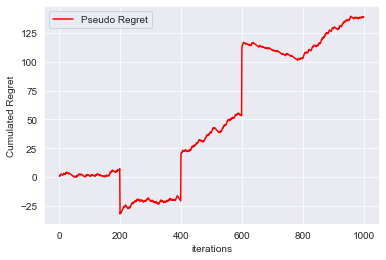

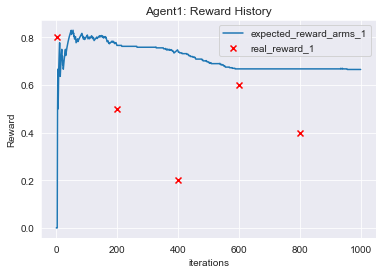

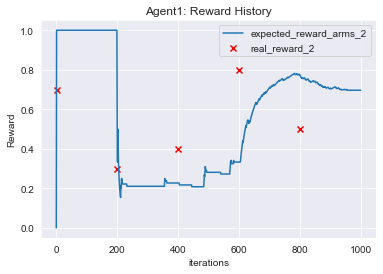

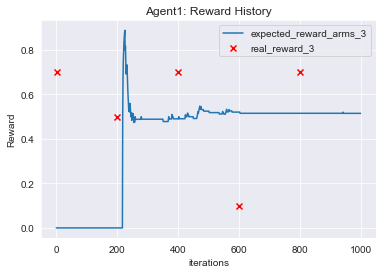

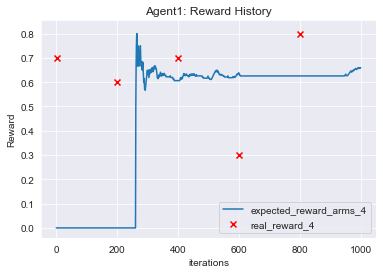

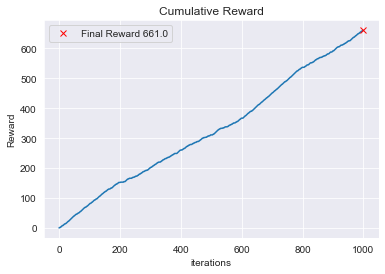

No handles with labels found to put in legend.


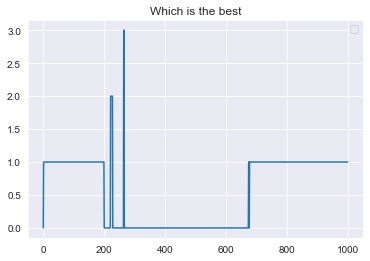

In [3]:
agent1 = IndependentAgent('Agent1', 1000, 'Binomial', [0.8, 0.2, 0.4, 0.3], 'step', 200)
agent1.start()
agent1.plot_regret()
for ind in range(4):
    agent1.plot_reward_history(ind)
agent1.plot_reward()
agent1.plot_prediction()

In [4]:
class ucb_bandit:
    def __init__(self, k, alpha, c, iters, m='random'):
        
        self.k = k #arms
        self.c = c # Exploratory parameter
        self.actions = np.arange(k) 
        self.iters = iters #Iterations
        self.n = 1 #Count
        self.k_n = np.ones(k) #Step count for each arm
        self.mean_reward = 0 #Total mean reward
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k) #Mean reward for each arm
        self.H = np.zeros(k) #Preferences
        self.alpha = alpha #Learning rate
        
        if type(m) == list or type(m).__module__ == np.__name__:           
            self.m = np.array(m)
        elif m == 'random':
            self.m = np.random.normal(0, 1, k)
        elif m == 'sequence':
            self.m = np.linspace(0, k-1, k)
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
    def pull(self):
        self.softmax()
        a = np.random.choice(self.actions, p=self.prob_action)
            
        reward = np.random.normal(self.m[a], 1)
        a = np.argmax(self.k_reward + self.c * np.sqrt(
                (np.log(self.n)) / self.k_n))
            
        reward = np.random.normal(self.m[a], 1)
        
        self.n += 1
        self.k_n[a] += 1
        
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        self.H[a] = self.H[a] + \
            self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[a])
        actions_not_taken = self.actions!=a
        self.H[actions_not_taken] = self.H[actions_not_taken] - \
            self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward #Running the algorithm
            
    def reset(self, m=None): #Resets all the parameters
        self.n = 1
        self.k_n = np.ones(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        self.H = np.zeros(self.k)
        if m == 'random':
            self.m = np.random.normal(0, 1, self.k)

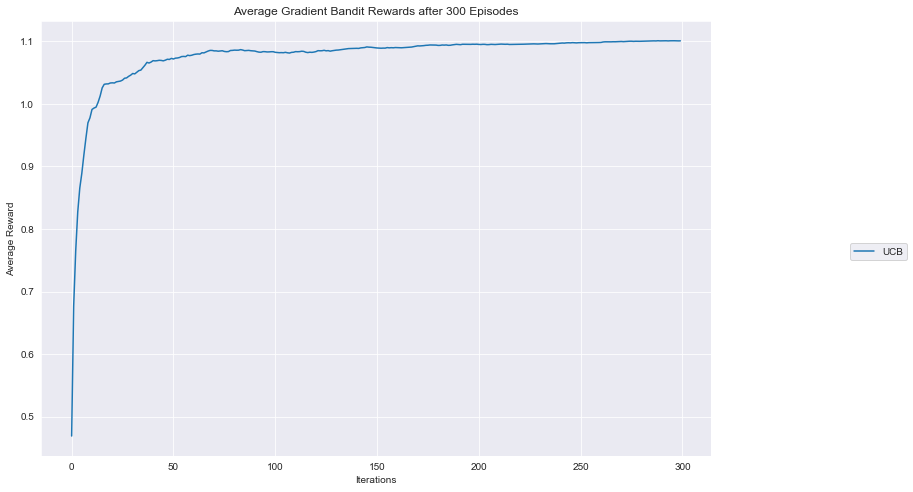

In [5]:
#Defining configurations and running bandit with learning rate

k = 10
iters = 300
ucb = ucb_bandit(k, 2, 0.1, iters, m='random')

ucb_rewards = np.zeros(iters)
opt_ucb = 0
episodes = 300
for i in range(episodes):
    ucb.reset()
    ucb.run()
    ucb_rewards = ucb_rewards + (
        ucb.reward - ucb_rewards) / (i + 1)
    opt_ucb += ucb.k_n[np.argmax(ucb.m)]
#Ploting results    
plt.figure(figsize=(12,8))
plt.plot(ucb_rewards, label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Gradient Bandit Rewards after " 
          + str(episodes) + " Episodes")
plt.show()